### Importação das bibliotecas

In [34]:
import pandas
from sklearn import model_selection
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')



### Importação do conjunto de dados

- Converte atributos usando o LabelEncoder
- Separa o x e y, onde y é a coluna que possui os labels.
- Divide o conjunto com 10% para treino
- Prepara os dados escalando valores para serem utilizados exclusivamente no modelo SVM.

In [25]:
#Importação do dataset, preparação dos dados e separação do conjunto de treino

dataset = pandas.read_csv("bank-full.csv", sep=';')
le = LabelEncoder()
for column_name in dataset.columns:
    if dataset[column_name].dtype == object:
        dataset[column_name] = le.fit_transform(dataset[column_name])
    else:
        pass
 
x = dataset.values[:, 0:16] 
y = dataset.values[:,16]

# separando em 10% treino
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.90, random_state = 1)

#Scaler para o modelo SVC
sc = StandardScaler()
sc.fit(x_train)
x_train_std = sc.transform(x_train)
x_test_std = sc.transform(x_test)

cv = model_selection.StratifiedKFold(n_splits=10, random_state=1)

### Modelos com as melhores configurações de parâmetros

- Para cada modelo, é passado os melhores parametros encontrados nas etapas anteriores
- Cria uma lista com todos os modelos.

In [26]:
#8. Definicao dos modelos de classificacao com as melhores configuracoes
# criacao dos modelos com os melhores parametros
dtc = DecisionTreeClassifier(min_samples_split=3, min_samples_leaf=2, max_depth=7, criterion='entropy')
knn = KNeighborsClassifier(weights='uniform', p=2, n_neighbors=9, metric='manhattan')
rfc = RandomForestClassifier(n_estimators=1600, min_samples_split=10, max_features='sqrt', max_depth=70, bootstrap=False, random_state=1)
svc = SVC(kernel='poly', gamma=0.01, C=10)

funcoes_pilha = [('lr', LogisticRegression()), ('knn', KNeighborsClassifier()), ('cart', DecisionTreeClassifier()), ('svm', SVC()), ('bayes', GaussianNB())]
stc = StackingClassifier(stack_method= 'predict', estimators=funcoes_pilha, final_estimator=LogisticRegression(), cv=5)

#adiciona os modelos em uma lista
models = []
models.append(('Arvore', dtc))
models.append(('SVM', svc))
models.append(('KNN', knn))
models.append(('Random Forest', rfc))
models.append(('Stack Pilha', stc))

results = []
names = []
scoring = 'accuracy'


### Execução do modelo experimental e teste de hipótese

- Para cada modelo, é realizada uma validação cruzada.
- O score de cada modelo é armazendo em results.

#### Hipótese
- H0: Os modelos possuem distribuições iguais.
- H1: Os modelos possuem distribuições diferentes.
    
Ao final é exibido a comparação entre alguns modelos

In [27]:
#10 Execucao do modelo experimental
#avaliacao de cada modelo nas amotragens estratificas
print('\nDesempenhos medios dos modelos:')
for name, model in models:
    #Se o modelo for SVM usa o train scaler.
    if name == 'SVM':
        cv_results = model_selection.cross_val_score(model, x_train_std, y_train, cv=cv, scoring=scoring, error_score='raise')
    else:
        cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring, error_score='raise')

    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

#11 Comparacao de modelos
# Teste de hipotese analisando o p-value
stat, p = stats.kruskal(results[0],results[1],results[2],results[3],results[4])
alpha = 0.05
if p > alpha:
	print('\nSame distributions (fail to reject H0)')
else:
	print('\nDifferent distributions (reject H0)')
print('\nComparison stats', stat)

print('Comparacao Random Forest | Arvore ->', stats.kruskal(results[3],results[0]))
print('Comparacao Random Forest | SVM ->', stats.kruskal(results[3],results[1]))
print('Comparacao Random Forest | KNN ->',stats.kruskal(results[3],results[2]))
print('Comparacao Random Forest | Stack ->',stats.kruskal(results[3],results[4]))
print('Comparacao Arvore | SVM ->',stats.kruskal(results[0],results[1]))
print('Comparacao Arvore | KNN ->',stats.kruskal(results[0],results[2]))
print('Comparacao Arvore | Stack ->',stats.kruskal(results[0],results[4]))	


Desempenhos medios dos modelos:
Arvore: 0.889184 (0.007098)
SVM: 0.880779 (0.002854)
KNN: 0.877684 (0.006224)
Random Forest: 0.903343 (0.010860)
Stack Pilha: 0.885201 (0.009158)

Different distributions (reject H0)

Comparison stats 27.450407916968334
Comparacao Random Forest | Arvore -> KruskalResult(statistic=7.245007564296528, pvalue=0.007109841490752865)
Comparacao Random Forest | SVM -> KruskalResult(statistic=14.328808446455497, pvalue=0.00015349779170582787)
Comparacao Random Forest | KNN -> KruskalResult(statistic=13.740662650602408, pvalue=0.0002098614483023187)
Comparacao Random Forest | Stack -> KruskalResult(statistic=9.923502653525391, pvalue=0.0016318154510088514)
Comparacao Arvore | SVM -> KruskalResult(statistic=6.0814393939393865, pvalue=0.01366094180273083)
Comparacao Arvore | KNN -> KruskalResult(statistic=7.456169568508702, pvalue=0.0063219388869915055)
Comparacao Arvore | Stack -> KruskalResult(statistic=2.089565879664887, pvalue=0.14830820876626064)


In [28]:
#treinamento dos modelos no conjunto de treino completo (sem divisao de validacao)
dtc.fit(x_train, y_train)
svc.fit(x_train_std, y_train)
knn.fit(x_train, y_train)
rfc.fit(x_train, y_train)
stc.fit(x_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression()),
                               ('knn', KNeighborsClassifier()),
                               ('cart', DecisionTreeClassifier()),
                               ('svm', SVC()), ('bayes', GaussianNB())],
                   final_estimator=LogisticRegression(),
                   stack_method='predict')

### Realiza a predição para cada modelo

Utiliza o conjunto de test

In [29]:
#predicao de cada modelo para a base de teste
Y_test_prediction_dtc = dtc.predict(x_test)
Y_test_prediction_svc = svc.predict(x_test)
Y_test_prediction_knn = knn.predict(x_test)
Y_test_prediction_rfc = rfc.predict(x_test)
Y_test_prediction_stc = stc.predict(x_test)

### Apresentação de resultados (acurácia, matriz de confusão, plot)

- Acurácia para Treinamento e Teste
- Relatório de classificação (precissão, recall, f1-score, support) para cada classe [0,1]
- Matriz de confusão.

Alguns modelos são muito bons em acertar a classe 0.


Acuracia Arvore: Treinamento 0.9194868391948684  Teste 0.890046694519538
Clasification report:               precision    recall  f1-score   support

           0       0.92      0.96      0.94     35945
           1       0.54      0.35      0.43      4745

    accuracy                           0.89     40690
   macro avg       0.73      0.66      0.68     40690
weighted avg       0.87      0.89      0.88     40690

Confussion matrix:
 [[34559  1386]
 [ 3088  1657]]

Acuracia SVM: Treinamento 0.8840964388409643  Teste 0.3575817154091914
Clasification report:               precision    recall  f1-score   support

           0       0.91      0.30      0.45     35945
           1       0.13      0.78      0.22      4745

    accuracy                           0.36     40690
   macro avg       0.52      0.54      0.34     40690
weighted avg       0.82      0.36      0.43     40690

Confussion matrix:
 [[10826 25119]
 [ 1021  3724]]

Acuracia KNN: Treinamento 0.8958195089581951  Teste 0

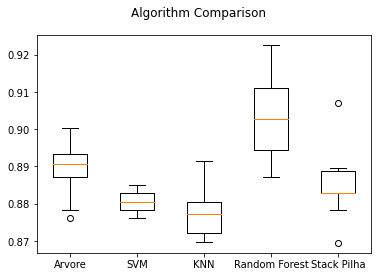

In [35]:
#12 Apresentacao de resultados
print("\nAcuracia Arvore: Treinamento",  dtc.score(x_train, y_train)," Teste" ,dtc.score(x_test, y_test))
print("Clasification report:", classification_report(y_test, Y_test_prediction_dtc))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_dtc))

print("\nAcuracia SVM: Treinamento",  svc.score(x_train_std, y_train)," Teste" ,svc.score(x_test, y_test))
print("Clasification report:", classification_report(y_test, Y_test_prediction_svc))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_svc))

print("\nAcuracia KNN: Treinamento",  knn.score(x_train, y_train)," Teste" ,knn.score(x_test, y_test))
print("Clasification report:", classification_report(y_test, Y_test_prediction_knn))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_knn))

print("\nAcuracia Comite Random Forest: Treinamento",  rfc.score(x_train, y_train)," Teste" ,rfc.score(x_test, y_test))
print("Clasification report:", classification_report(y_test, Y_test_prediction_rfc))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_rfc))

print("\nAcuracia Comite Stack: Treinamento",  stc.score(x_train, y_train)," Teste" ,stc.score(x_test, y_test))
print("Clasification report:", classification_report(y_test, Y_test_prediction_stc))
print("Confussion matrix:\n", confusion_matrix(y_test, Y_test_prediction_stc))
      
      
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()	